In [403]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings 

warnings.filterwarnings("ignore")

In [404]:
rental=pd.read_csv("day.csv")

In [405]:
rental.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Step 1: Reading and Understanding the Data

#### Checking the missing values-

In [406]:
rental.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### To check if there are any missing values in the dataset
There are no missing values present in the dataset.

In [407]:
rental.rename(columns={"yr":"Year","mnth":"month","hum":"humidity","cnt":"count"},inplace=True)
rental.head()

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### The  info tells us that   the features like season, month,weekday  are being interpreted as numerical values. So that should be changed to make sense so we change their datatypes.

In [408]:
#Convert values of season feature 1:spring, 2:summer, 3:fall, 4:winter

def convert_val(x):
    if x==1:
        return 'spring'
    elif x==2:
        return 'summer'
    elif x==3:
        return 'fall'
    else:
        return 'winter'

In [409]:
rental['season']=rental['season'].apply(convert_val)

In [410]:
#check the data type of season
rental.season.dtype

dtype('O')

In [411]:
#Mapping variables sesson,mounth,weathersit,weekday
rental['month']=rental.month.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
rental['weathersit']=rental.weathersit.map({1: 'Clear',2:'Mist + Cloudy',3:'Light Snow',4:'Snow + Fog'})
rental['weekday']=rental.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})


In [412]:
rental.head()

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,01-01-2018,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Handling the date column -
We can find out the number of days since the first bike was rented out to get a clearer idea of the number of rentals made to draw conclusions later as we build the model.

In [413]:
rental['dteday'] =  pd.to_datetime(rental['dteday'],format='%d-%m-%Y')


In [414]:
rental['dteday'].dtype

dtype('<M8[ns]')

In [415]:
# Converting date to Pandas datetime format
rental['dteday'] = pd.to_datetime(rental['dteday'])

In [416]:
# Deriving "days since the rental of bikes started"
from datetime import date

d0 = pd.to_datetime(date(2018, 1, 1))
d1 = rental.dteday
delta = d1 - d0
rental['day']= delta

In [417]:
# Cleaning days
rental['day'] = rental['day'].astype(str)
rental['day'] = rental['day'].map(lambda x: x[0:2])
rental['day'] = rental['day'].astype(int)

In [418]:
rental.head()

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,2018-01-01,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,2018-01-02,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,2018-01-03,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,2018-01-04,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,2018-01-05,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


In [419]:
#determining the number of rows and columns
rental.shape

(730, 17)

In [420]:
#summary of all the numeric columns in the dataset
rental.describe()

,instant,Year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,day
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849,42.164384
std,210.877136,0.500343,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647,20.214226
min,1.000000,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000,0.000000
25%,183.250000,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000,25.000000
50%,365.500000,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000,42.000000
75%,547.750000,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000,58.000000
max,730.000000,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000,99.000000


In [421]:
rental.nunique().sort_values()

workingday      2
Year            2
holiday         2
weathersit      3
season          4
weekday         7
month          12
day           100
temp          498
humidity      594
casual        605
windspeed     649
registered    678
atemp         689
count         695
dteday        730
instant       730
dtype: int64

In [422]:
rental.head()

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,2018-01-01,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,2018-01-02,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,2018-01-03,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,2018-01-04,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,2018-01-05,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


In [423]:
rental['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [424]:
rental.drop(['day'],axis=1,inplace=True)

In [425]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   Year        730 non-null    int64         
 4   month       730 non-null    object        
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    object        
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    object        
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  humidity    730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  count       730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [426]:
rental.sample(6)

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
709,710,2019-12-11,winter,1,Dec,0,Wed,1,Mist + Cloudy,14.486653,16.91815,59.6667,19.834479,282,5219,5501
654,655,2019-10-17,winter,1,Oct,0,Thu,1,Clear,18.689153,22.50540,69.2917,6.791857,979,6482,7461
206,207,2018-07-26,fall,0,July,0,Thu,1,Clear,31.638347,34.84895,54.0833,13.417286,750,3840,4590
692,693,2019-11-24,winter,1,Nov,0,Sun,0,Clear,11.411653,12.43710,40.4583,25.250357,532,1745,2277
320,321,2018-11-17,winter,0,Nov,0,Sat,0,Mist + Cloudy,14.008347,16.16105,57.5833,20.459254,139,2914,3053
370,371,2019-01-06,spring,1,Jan,0,Sun,0,Clear,13.700847,17.01335,54.2083,11.249836,307,3791,4098


In [427]:
rental['month'].value_counts()

Aug     62
Jan     62
Mar     62
Dec     62
July    62
Oct     62
May     62
Nov     60
Apr     60
Sep     60
June    60
Feb     56
Name: month, dtype: int64

In [428]:
rental.head()

,instant,dteday,season,Year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2018-01-01,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Step 2: Visualising the Data

In [429]:
rental.nunique().sort_values()

Year            2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
month          12
temp          498
humidity      594
casual        605
windspeed     649
registered    678
atemp         689
count         695
instant       730
dteday        730
dtype: int64

#### 1: Season

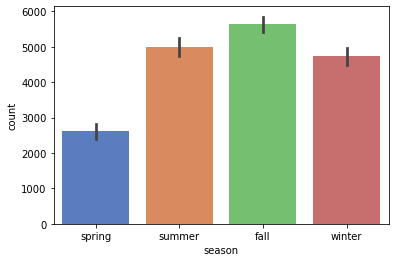

In [430]:
#barplot to see relation between season and count of bike rentals
sns.barplot('season','count',data=rental,palette="muted",)
plt.show()

Bike Rentals are more during the Fall season.

#### 2: Weathersit
1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

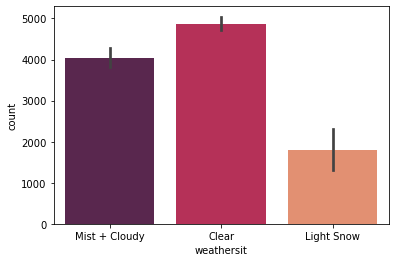

In [431]:
sns.barplot("weathersit","count",palette="rocket",data=rental)
plt.show()

Bikes seem to be rented more in Clear weather.

#### 3: Year -
Bike Rental popularity has increased in 2019 when compared to 2018.

2018:0

2019:1

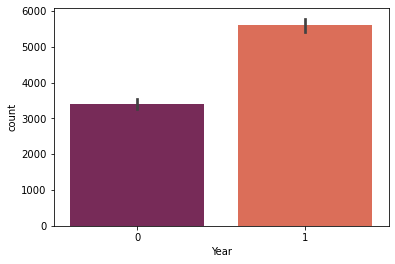

In [432]:
sns.barplot("Year","count",palette="rocket",data=rental)
plt.show()

#### 4:Month
1:Jan
2:Feb
3:Mar
4:Apr
5:May
6:June
7:July
8:Aug
9:Sep
10:Oct
11:Nov
12:Dec

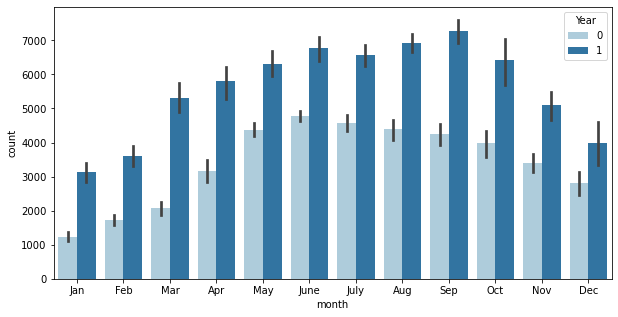

In [433]:
plt.figure(figsize=(10,5))
sns.barplot("month","count",hue="Year",data=rental,palette="Paired")
plt.show()

#### 5:Temperature- temp
Bike Rentals are observed at higher temperatures.


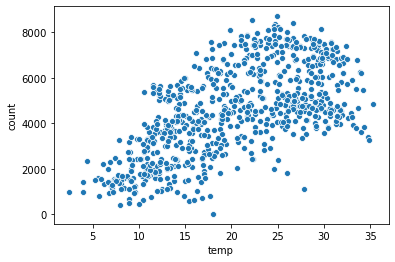

In [434]:
sns.scatterplot(x="temp",y="count",data=rental)
plt.show()

#### 6:Temperature- atemp
Bike Rentals are observed at higher "feel-like" temperatures.

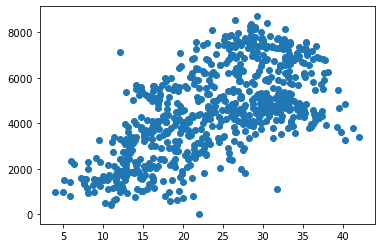

In [435]:
plt.scatter('atemp','count',data=rental)
plt.show()

#### 7.Humidity
Temperature being directly proportional to Humidity, Bike Rentals are making during high humidity

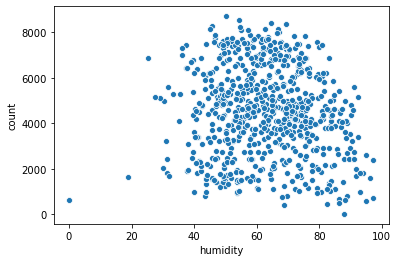

In [436]:
sns.scatterplot(x="humidity",y="count",data=rental)
plt.show()

#### 8.Working Day
Bikes seem to be rented more on working days.

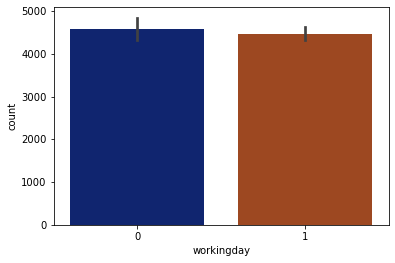

In [437]:
#barplot to see relation between season and count of bike rentals
sns.barplot('workingday','count',data=rental,palette="dark",)
plt.show()

#### 9.Windspeed 
Wind speeds increase with a greater temperature difference.Wind speed near the surface is most highly correlated with the temperature.

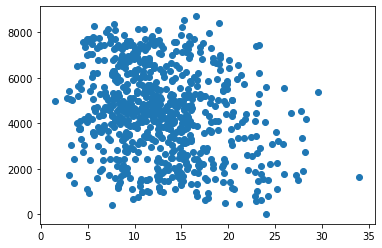

In [438]:
#barplot to see relation between season and count of bike rentals
plt.scatter('windspeed','count',data=rental)

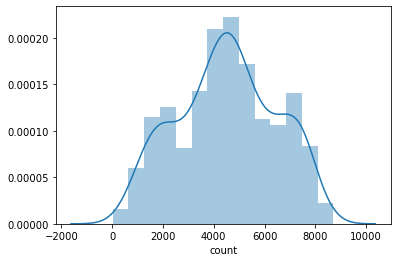

In [439]:
sns.distplot(rental['count'])

#### Visualizing the Relationship among variables

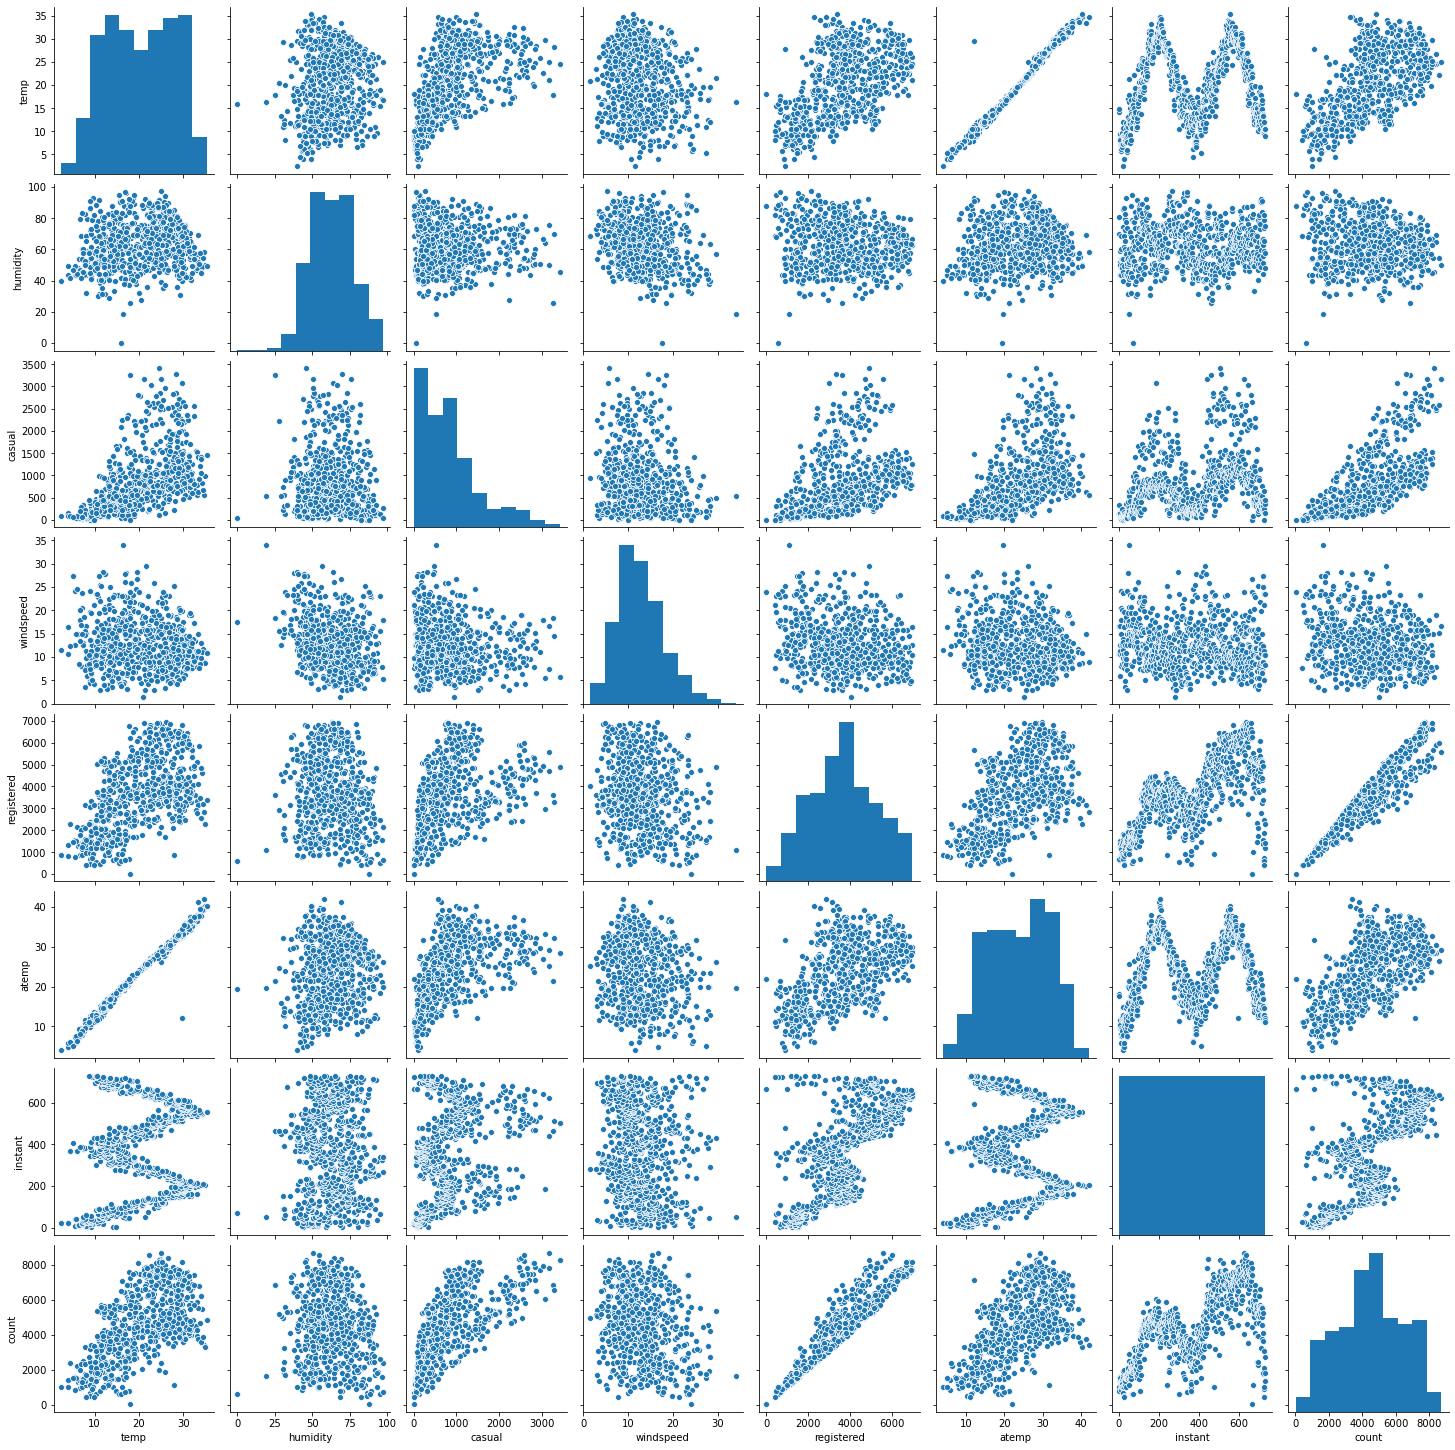

In [440]:
#Visualising Numeric Variables
sns.pairplot(rental,vars=["temp","humidity","casual","windspeed","registered","atemp","instant","count"])
plt.show()

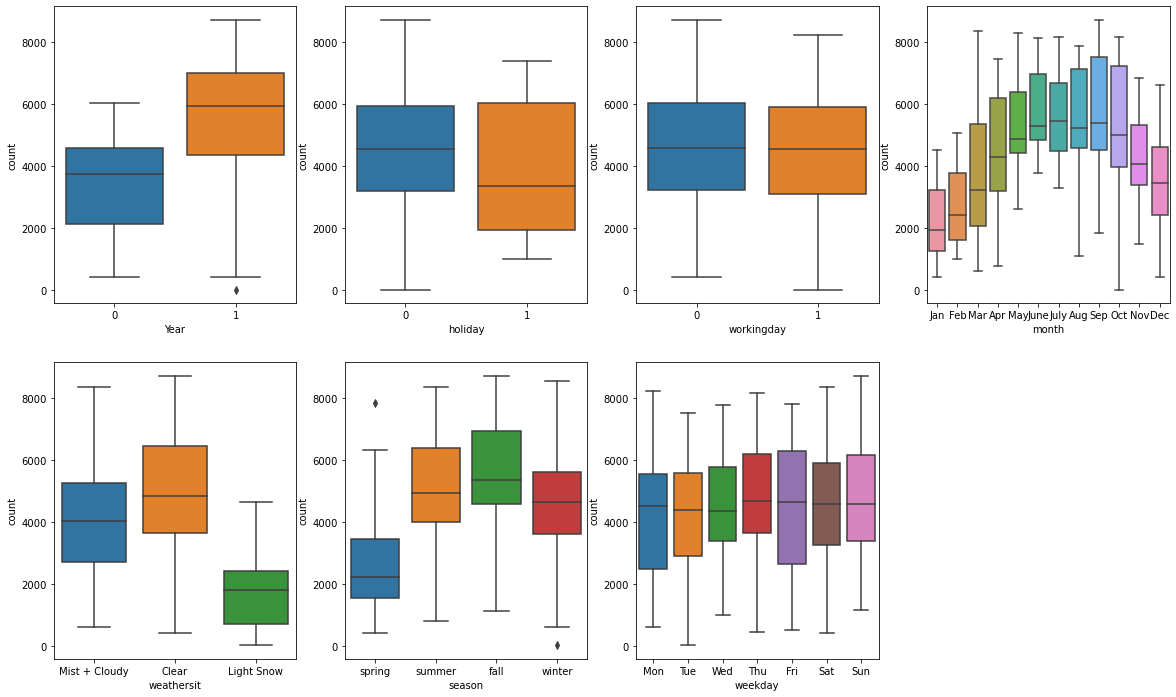

In [441]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'Year', y = 'count', data = rental)
plt.subplot(2,4,2)
sns.boxplot(x = 'holiday', y = 'count', data =rental)
plt.subplot(2,4,3)
sns.boxplot(x = 'workingday', y = 'count', data =rental)
plt.subplot(2,4,4)
sns.boxplot(x = 'month', y = 'count', data = rental)
plt.subplot(2,4,5)
sns.boxplot(x = 'weathersit', y = 'count', data = rental)
plt.subplot(2,4,6)
sns.boxplot(x = 'season', y = 'count', data =rental)
plt.subplot(2,4,7)
sns.boxplot(x = 'weekday', y = 'count', data = rental)
plt.show()

#### Inference-

-  Bike Rentals are more in the year 2019 compared to 2018.As mentioned in the problem statement cnt values are high in 2019 than in 2018.
- September month logged highest count. Months March and Octboer has great spread in data. May, June, July seems to be the months that will generate high counts.
- As intuition suggests count is high when weather is clear and low when it is snowing
- Spring season has the low count and fall has the high count
- Among the days of the week the difference is not extreme.

#### Heatmap

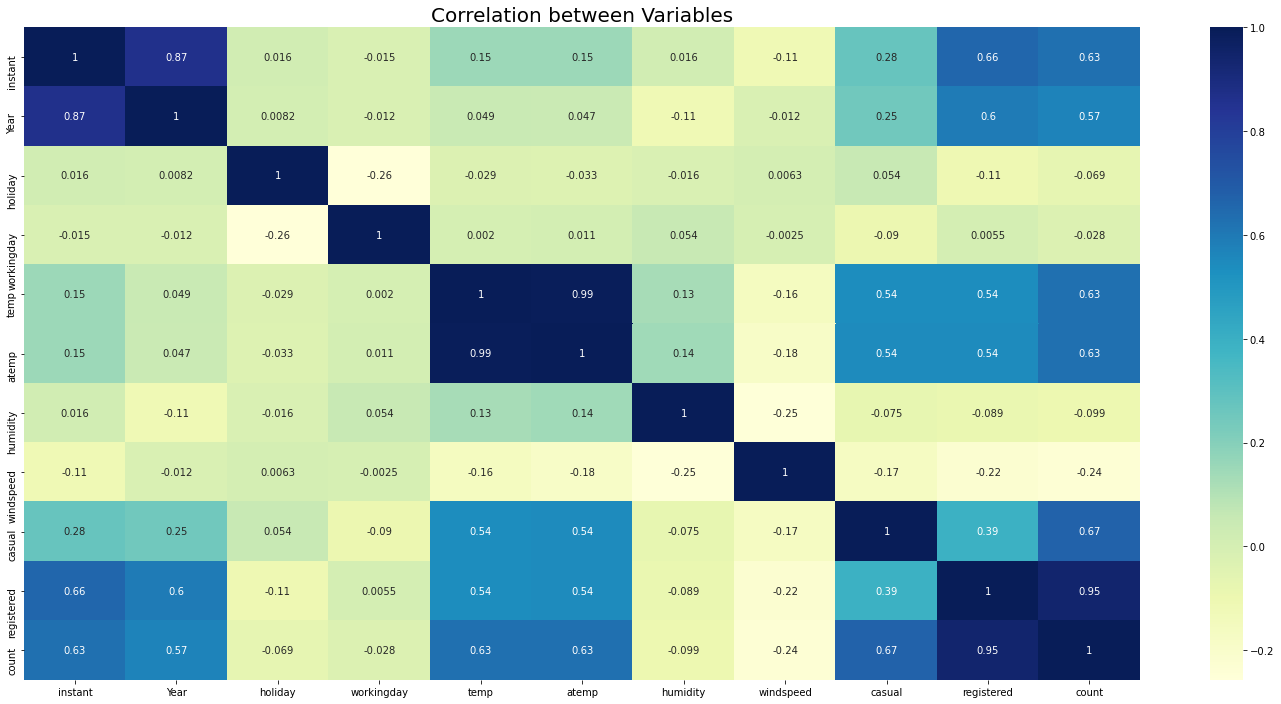

In [442]:
plt.figure(figsize=(25,12))
sns.heatmap(rental.corr(),cmap="YlGnBu",annot=True)
plt.title("Correlation between Variables",fontsize=20)
plt.show()

It is visible from the pairplot and the heatmap,we can see temp,atemp,casual,registered ,instant variables are correlated to "count" variable.
We can also see some other varibales are also most correlated. We know that atemp can be dropped in future and that casual and registered sum up to count and can be dropped in future before the modelling part .
Both the plots above helps to interpret the data well and identify the variables 
that can turn out be useful in building the model
Hence we can consider a Linear Regression Model.

In [443]:
rental.describe().columns # numerical col names

Index(['instant', 'Year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [444]:
num_col = rental[['instant', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'Year']]
num_col

,instant,temp,atemp,humidity,windspeed,casual,registered,count,Year
0,1,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0
2,3,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0
3,4,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0
4,5,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0
...,...,...,...,...,...,...,...,...,...
725,726,10.420847,11.33210,65.2917,23.458911,247,1867,2114,1
726,727,10.386653,12.75230,59.0000,10.416557,644,2451,3095,1
727,728,10.386653,12.12000,75.2917,8.333661,159,1182,1341,1
728,729,10.489153,11.58500,48.3333,23.500518,364,1432,1796,1


In [445]:
x = num_col.columns
x

Index(['instant', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'Year'],
      dtype='object')

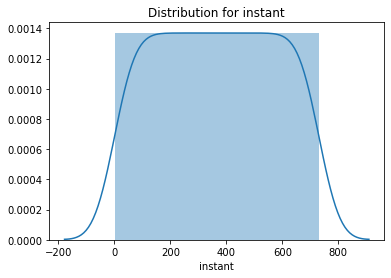

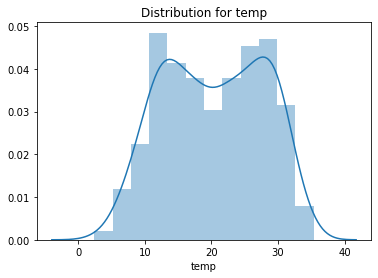

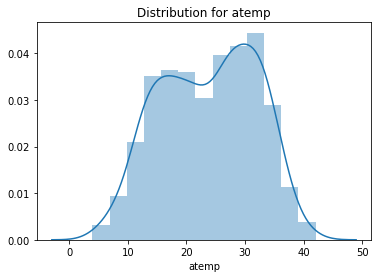

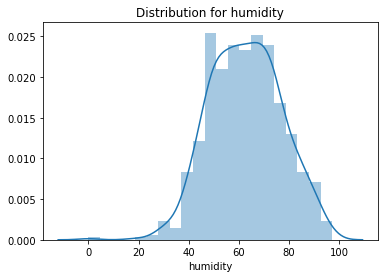

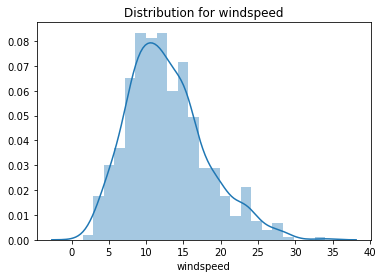

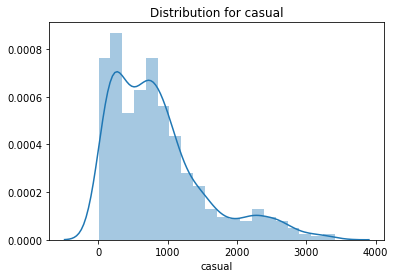

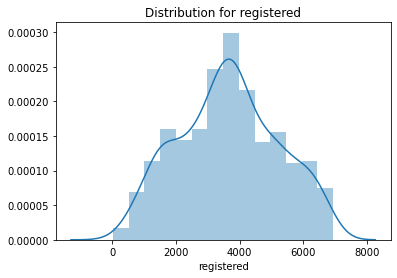

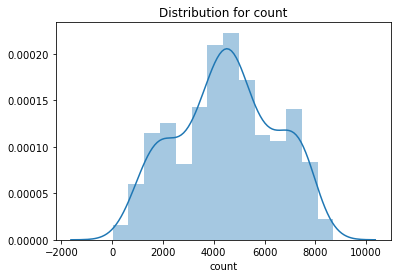

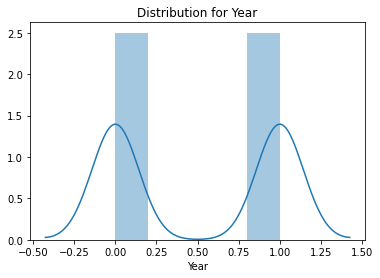

In [446]:
for col in x:
    sns.distplot(rental[col])
    plt.title("Distribution for "+col)
    plt.show();
    print("==================================================================================")

#### Inference-

Temp and atemp are bimodal in nature and one can be eliminated . Casual and Registered together will sum up to the count and can be further eliminated .


In [447]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   Year        730 non-null    int64         
 4   month       730 non-null    object        
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    object        
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    object        
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  humidity    730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  count       730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [448]:
# Visualize Categorical Columns
rental.dtypes


instant                int64
dteday        datetime64[ns]
season                object
Year                   int64
month                 object
holiday                int64
weekday               object
workingday             int64
weathersit            object
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [449]:
rental.columns

Index(['instant', 'dteday', 'season', 'Year', 'month', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [450]:
cat_df = rental[['season', 'Year', 'month', 'holiday', 'weekday', 'workingday', 'weathersit']]
cat_df

,season,Year,month,holiday,weekday,workingday,weathersit
0,spring,0,Jan,0,Mon,1,Mist + Cloudy
1,spring,0,Jan,0,Tue,1,Mist + Cloudy
2,spring,0,Jan,0,Wed,1,Clear
3,spring,0,Jan,0,Thu,1,Clear
4,spring,0,Jan,0,Fri,1,Clear
...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Fri,1,Mist + Cloudy
726,spring,1,Dec,0,Sat,0,Mist + Cloudy
727,spring,1,Dec,0,Sun,0,Mist + Cloudy
728,spring,1,Dec,0,Mon,1,Clear


In [451]:
cat_df.columns

Index(['season', 'Year', 'month', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

In [452]:
x

Index(['instant', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'Year'],
      dtype='object')

In [453]:
x = x[1:]
x

Index(['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count', 'Year'],
      dtype='object')

In [454]:
rental[x].head()

,temp,atemp,humidity,windspeed,casual,registered,count,Year
0,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,14.902598,17.68695,69.6087,16.652113,131,670,801,0
2,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0
3,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0
4,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0


In [455]:
rental[x].corr()

,temp,atemp,humidity,windspeed,casual,registered,count,Year
temp,1.000000,0.991696,0.128565,-0.158186,0.542731,0.539436,0.627044,0.048789
atemp,0.991696,1.000000,0.141512,-0.183876,0.543362,0.543678,0.630685,0.047215
humidity,0.128565,0.141512,1.000000,-0.248506,-0.075211,-0.089212,-0.098543,-0.112547
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.167995,-0.217914,-0.235132,-0.011624
casual,0.542731,0.543362,-0.075211,-0.167995,1.000000,0.394137,0.672123,0.250502
registered,0.539436,0.543678,-0.089212,-0.217914,0.394137,1.000000,0.945411,0.596911
count,0.627044,0.630685,-0.098543,-0.235132,0.672123,0.945411,1.000000,0.569728
Year,0.048789,0.047215,-0.112547,-0.011624,0.250502,0.596911,0.569728,1.000000


#### Heatmap

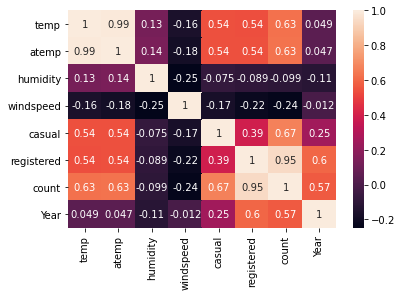

In [456]:
sns.heatmap(rental[x].corr(),annot=True)

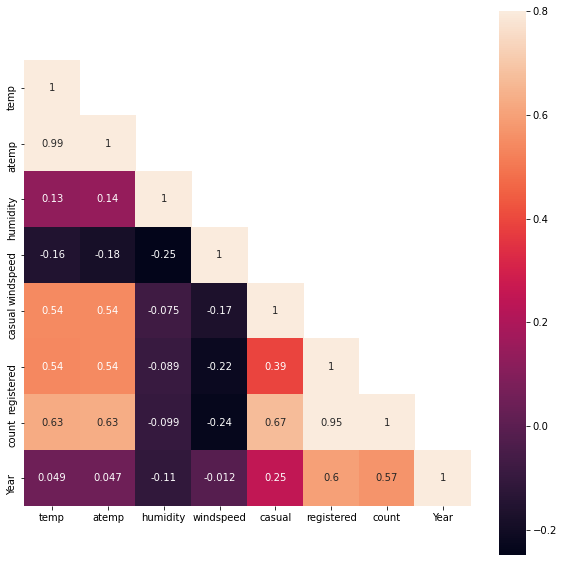

In [457]:
# heatmap - plotting the correlation matrix and applying the masking technique
mask = np.array(rental[x].corr())
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(rental[x].corr(), mask=mask, vmax=0.8, square=True, annot=True);

## Step 3: Data Prepartion

In [458]:
#drop unnecessary columns
rental=rental.drop(["instant","dteday","casual","registered","atemp"],axis=1)
rental.head()

,season,Year,month,holiday,weekday,workingday,weathersit,temp,humidity,windspeed,count
0,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


##### Dummy Encoding- Handling the Dummy variables

In [459]:
# Select all categorical variables
df_categorical = rental.select_dtypes(include=['object'])
df_categorical.columns

Index(['season', 'month', 'weekday', 'weathersit'], dtype='object')

In [460]:
# convert categorical values into dummies
df_dummies = pd.get_dummies(df_categorical,drop_first=True)
df_dummies.head()

,season_spring,season_summer,season_winter,month_Aug,month_Dec,month_Feb,month_Jan,month_July,month_June,month_Mar,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [461]:
list(df_categorical.columns)
rental = rental.drop(list(df_categorical.columns),axis=1)
rental.columns

Index(['Year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'count'],
      dtype='object')

In [462]:
df = pd.concat([rental, df_dummies], axis=1)
df.head()

,Year,holiday,workingday,temp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [463]:
df.columns

Index(['Year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'count', 'season_spring', 'season_summer', 'season_winter', 'month_Aug',
       'month_Dec', 'month_Feb', 'month_Jan', 'month_July', 'month_June',
       'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'weathersit_Light Snow',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [464]:
rental.shape

(730, 7)

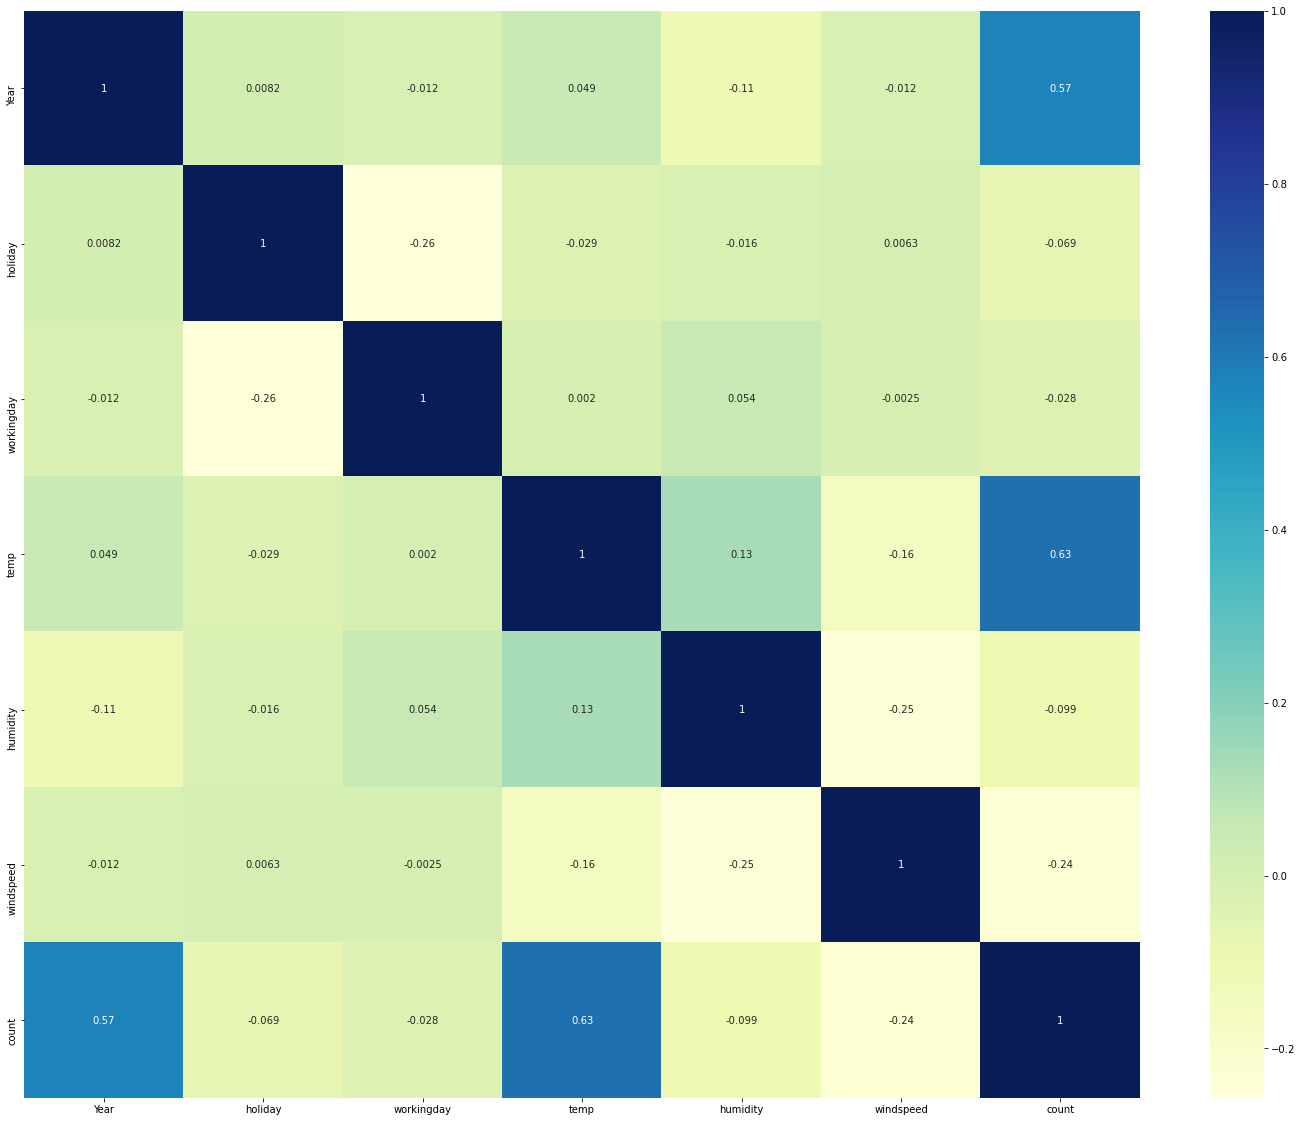

In [465]:
#Now lets check the correlation between variables again
#heatmap to see correlation between variables
plt.figure(figsize=(25,20))
sns.heatmap(rental.corr(),cmap="YlGnBu",annot=True)
plt.show()

Inference -We can see that Temperature is greater during Summer season,June ,October months have good correlation with the count variable and seem
to have good influence on the number of bike rentals.

## Step 4: Scaling and Splitting the Data into Training and Testing Sets
 #### There are few methods of scaling of Data in order to perform modelling . In this case we will be using Min-Max Scalar method to proceed . 
1. Standard Scalar Method (Scaling is done and value is between and around 1 similar to z-score)
2. Min-Max Scalar Method (Scaling is done between 0 and 1 ) 
3. Rhobust Method (Outliers are checked with the inter-quartile range )

#### Dividing into X and Y sets for the model building

In [466]:
#Method 1 - Min-Max scaling -
#splitting the data into Training and Testing Sets
#splitting the data into Training and Testing Sets
df_train,df_test=train_test_split(df,train_size=0.7,random_state=100)

In [467]:
list(rental.describe().columns)

['Year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'count']

In [468]:
print(df_test.shape)
print(df_train.shape)

(220, 29)
(510, 29)


In [469]:
scaler=MinMaxScaler()
num_vars=["temp","humidity","windspeed","count"]
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_train.head()

,Year,holiday,workingday,temp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,1,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,0,0,1,0,0,0,0,1
111,0,0,0,0.345824,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,1,0,0,0,0,1


After performing scaling method all the numeric variables are now mapped between 0 and 1

In [470]:
y_train=df_train.pop("count")
X_train=df_train

#### Multicollinarity: This assumes that predictors are not correlated with each other ,if there is correlation among the predictors
Delecting multi-collinearity is detecting association in predictors we plot scatterplots and correlation matrix to quantify linear association.

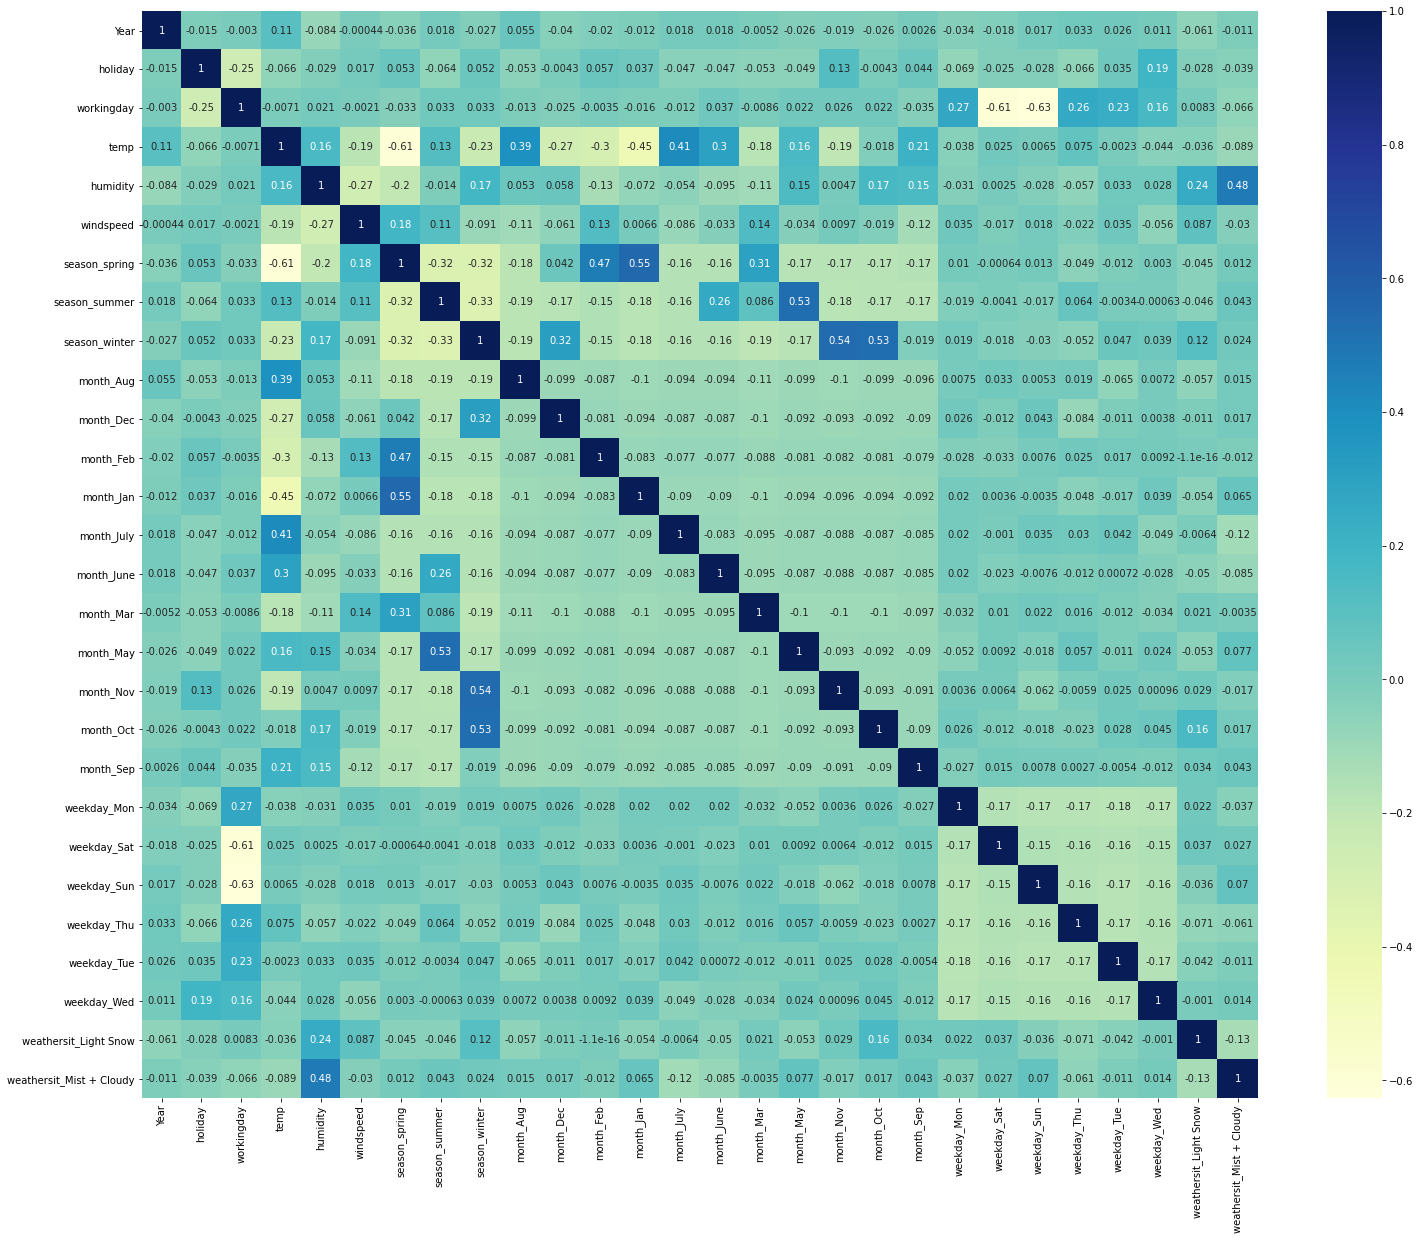

In [471]:
plt.figure(figsize=(25,20))
sns.heatmap(df_train.corr(),cmap='YlGnBu',annot=True)
plt.show()

#### Inference- 
From the heatmap we can see temp,year are correlated to the "count" variable.Even in August and September months we can see the counts are little higher.

## Step 5: Building a linear model

####  Model Selection Criteria used-Using Recursive feature elimination(RFE) -
for automated Feature Selection approach
This approach deals with repeatedly constructing a model(SM or regression model ) and choosing the best or worst performing feature setting the feature aside and repeating the process.

In this case we are using an  Automated approach RFE for the top 'n' features. We could also use Model selection criteria AIC , BIC and Mallow's CP.

In [472]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [473]:
# Running RFE with the output number of the variable equal to 10
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm,15)
rfe=rfe.fit(X_train,y_train)

In [474]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('month_Aug', False, 9),
 ('month_Dec', True, 1),
 ('month_Feb', False, 2),
 ('month_Jan', True, 1),
 ('month_July', True, 1),
 ('month_June', False, 11),
 ('month_Mar', False, 14),
 ('month_May', False, 8),
 ('month_Nov', True, 1),
 ('month_Oct', False, 12),
 ('month_Sep', True, 1),
 ('weekday_Mon', False, 7),
 ('weekday_Sat', False, 4),
 ('weekday_Sun', False, 5),
 ('weekday_Thu', False, 13),
 ('weekday_Tue', False, 6),
 ('weekday_Wed', False, 10),
 ('weathersit_Light Snow', True, 1),
 ('weathersit_Mist + Cloudy', True, 1)]

In [475]:
#Columns where RFE support is True
col=X_train.columns[rfe.support_]
col

Index(['Year', 'holiday', 'temp', 'humidity', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'month_Dec', 'month_Jan',
       'month_July', 'month_Nov', 'month_Sep', 'weathersit_Light Snow',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [476]:
#Columns where RFE support is FAlSE
X_train.columns[~rfe.support_]
#Create X_test dataFrame with RFE selected variables
X_train_rfe=X_train[col]

While choosing a model we choose high p-value and high VIF values to drop first 
Then High p-value and low VIF values to remove next 
Followed by low p-value and high VIF values after
Low p-value and low VIF values at the end to improve the modelling .

In [477]:
import statsmodels.api as sm

#Adding a constant variables
X_train_rfe=sm.add_constant(X_train_rfe)

#### Running Linear model lm1 -

In [478]:
#Running the linear model
lm=sm.OLS(y_train,X_train_rfe).fit()

In [479]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          8.15e-189
Time:                        16:26:41   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Now we have all the variables with p-value less than 0.05

#### Checking VIF
Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. VIF is an indicator of multicollinearity .The formula for calculating VIF is:

VIFi=1/(1−Ri2)

In [480]:
#Drop the Constant term
X_train_rfe=X_train_rfe.drop(["const"],axis=1)

In [481]:
#Calculate the VIFs for the new model
vif=pd.DataFrame()
X=X_train_rfe
vif["Features"]=X.columns
vif["VIF"]=[variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif["VIF"]=round(vif["VIF"],2)
vif=vif.sort_values(by="VIF",ascending=False)
print(vif)

                    Features    VIF
3                   humidity  30.89
2                       temp  17.79
4                  windspeed   4.72
5              season_spring   4.37
7              season_winter   4.06
6              season_summer   2.82
14  weathersit_Mist + Cloudy   2.32
0                       Year   2.09
11                 month_Nov   1.85
9                  month_Jan   1.75
10                month_July   1.59
8                  month_Dec   1.56
12                 month_Sep   1.41
13     weathersit_Light Snow   1.28
1                    holiday   1.06


#### Inference -
- we drop the variables which have VIF values larger than 5 .

In [482]:
#Drop Humidity value 
X_train_new1=X_train_rfe.drop(["humidity"],axis=1)

In [483]:
#Build a model
X_train_lm1=sm.add_constant(X_train_new1)
lm1=sm.OLS(y_train,X_train_lm1).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.5
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          4.75e-186
Time:                        16:26:41   Log-Likelihood:                 504.85
No. Observations:                 510   AIC:                            -979.7
Df Residuals:                     495   BIC:                            -916.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [484]:
#Drop the Constant Term
X_train_lm1=X_train_lm1.drop(["const"],axis=1)

In [485]:
#calculating the VIFs for the new model
vif=pd.DataFrame()
X=X_train_new1
vif["Features"]=X.columns
vif["VIF"]=[variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif["VIF"]=round(vif["VIF"],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
2,temp,5.17
3,windspeed,4.67
6,season_winter,2.95
4,season_spring,2.89
5,season_summer,2.24
0,Year,2.07
10,month_Nov,1.81
8,month_Jan,1.66
9,month_July,1.59
13,weathersit_Mist + Cloudy,1.57


#### Running Linear model lm2 -

In [486]:
#Drop Temp
X_train_new2=X_train_lm1.drop(["temp"],axis=1)

#Build a model
X_train_lm2=sm.add_constant(X_train_new2)
lm2=sm.OLS(y_train,X_train_lm2).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     144.9
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          1.82e-159
Time:                        16:26:41   Log-Likelihood:                 438.84
No. Observations:                 510   AIC:                            -849.7
Df Residuals:                     496   BIC:                            -790.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [487]:
#Drop the constant
X_train_lm2=X_train_lm2.drop(["const"],axis=1)

In [488]:
# Calculate the VIFs for the new model
vif = pd.DataFrame()
X = X_train_new2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.89
3,season_spring,2.89
5,season_winter,2.85
4,season_summer,2.02
0,Year,1.83
9,month_Nov,1.80
7,month_Jan,1.64
12,weathersit_Mist + Cloudy,1.53
6,month_Dec,1.46
8,month_July,1.20


#### Running Linear model lm3 -

In [489]:
#Drop the July column as it has a high p-value 
X_train_new3=X_train_lm2.drop(['month_July'],axis=1)

In [490]:
# Adding a constant variable 
X_train_lm3 = sm.add_constant(X_train_new3)
lm3 = sm.OLS(y_train,X_train_lm3).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     157.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          2.08e-160
Time:                        16:26:41   Log-Likelihood:                 438.45
No. Observations:                 510   AIC:                            -850.9
Df Residuals:                     497   BIC:                            -795.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [491]:
#Drop constant 
X_train_lm3=X_train_lm3.drop(['const'],axis=1)

In [492]:
# Calculate the VIFs for the new model
vif = pd.DataFrame()
X = X_train_new3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.52
5,season_winter,2.75
3,season_spring,2.71
4,season_summer,1.87
8,month_Nov,1.80
0,Year,1.77
7,month_Jan,1.64
11,weathersit_Mist + Cloudy,1.52
6,month_Dec,1.46
9,month_Sep,1.16


#### Running Linear model lm4 -

In [503]:
#drop season_winter taking p-value into consideration
X_train_new4=X_train_lm3.drop(["season_winter"],axis=1)

In [504]:
#Build a model
X_train_lm4= sm.add_constant(X_train_new4)
lm4= sm.OLS(y_train,X_train_lm4).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     171.2
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          2.71e-161
Time:                        16:30:50   Log-Likelihood:                 437.88
No. Observations:                 510   AIC:                            -851.8
Df Residuals:                     498   BIC:                            -800.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [505]:
#Drop Constant
X_train_lm4=X_train_lm4.drop(["const"],axis=1)

In [497]:
#Calculate the VIFS  for the new model
vif = pd.DataFrame()
X = X_train_new4
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.23
3,season_spring,2.37
0,Year,1.74
4,season_summer,1.70
6,month_Jan,1.62
10,weathersit_Mist + Cloudy,1.48
7,month_Nov,1.23
8,month_Sep,1.16
5,month_Dec,1.13
9,weathersit_Light Snow,1.07


When we drop the 'holiday' variable with low VIF value and p-value there is no change in the R-ssquare value hence we will not consider this model for prediction . R-squared does not penalise the model for having more number of variables , any variable added will increase its predictive power.Adjusted r-squared penalises the model on the basis of the number of variables present in them ,if adjusted R-square drops we can be sure that the variable is insignificant.

#### Running Linear model lm5 -

In [499]:
#drop season_winter taking p-value into consideration
X_train_new5=X_train_lm4.drop(["holiday"],axis=1)

In [500]:
#Build a model
X_train_lm5= sm.add_constant(X_train_new4)
lm5= sm.OLS(y_train,X_train_lm5).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     171.2
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          2.71e-161
Time:                        16:27:52   Log-Likelihood:                 437.88
No. Observations:                 510   AIC:                            -851.8
Df Residuals:                     498   BIC:                            -800.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [501]:
#Drop Constant
X_train_lm5=X_train_lm5.drop(["const"],axis=1)

In [502]:
#Calculate the VIFS  for the new model
vif = pd.DataFrame()
X = X_train_new5
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,windspeed,3.22
2,season_spring,2.36
0,Year,1.74
3,season_summer,1.70
5,month_Jan,1.62
9,weathersit_Mist + Cloudy,1.48
6,month_Nov,1.20
7,month_Sep,1.15
4,month_Dec,1.13
8,weathersit_Light Snow,1.06


The p-values represent the significance of the variables and VIF which represent how variables are correlated to each other. Based on these two parameters we decided which variable to drop.
The VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.
- The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis.

- A rule of thumb commonly used in practice is if a VIF is > 10, you have high multicollinearity. In our case, with values less than 5, we are in good shape, and can proceed with our regression

- R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. 


## Step 6: Residual Analysis of model

In [111]:
X_train_lm4=sm.add_constant(X_train_lm4)
X_train_lm4

,const,Year,holiday,windspeed,season_spring,season_summer,month_Dec,month_Jan,month_Nov,month_Sep,weathersit_Light Snow,weathersit_Mist + Cloudy
576,1.0,1,0,0.264686,0,0,0,0,0,0,0,0
426,1.0,1,0,0.255342,1,0,0,0,0,0,0,1
728,1.0,1,0,0.663106,1,0,1,0,0,0,0,0
482,1.0,1,0,0.188475,0,1,0,0,0,0,0,1
111,1.0,0,0,0.380981,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
578,1.0,1,0,0.187140,0,0,0,0,0,0,0,0
53,1.0,0,0,0.111379,1,0,0,0,0,0,0,0
350,1.0,0,0,0.431816,0,0,1,0,0,0,0,1
79,1.0,0,0,0.529881,0,1,0,0,0,0,0,1


#### We are considering Lm 4 to proceed -

In [112]:
#y train predicted
y_train_pred = lm4.predict(X_train_lm4)

<Figure size 432x288 with 0 Axes>

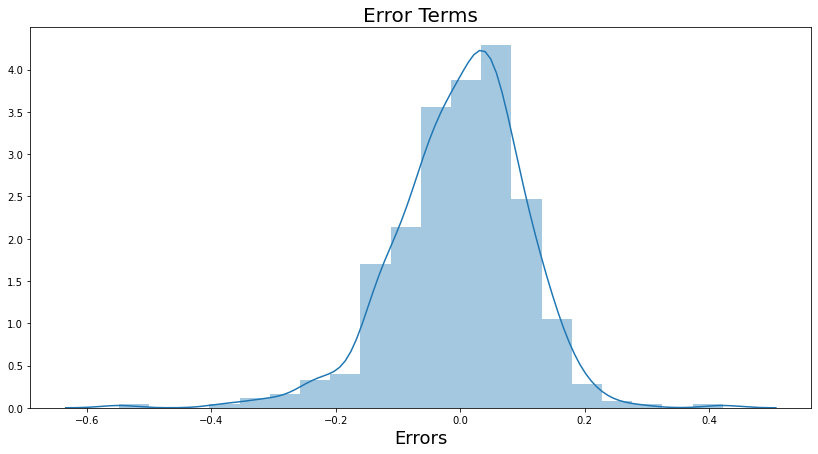

In [113]:

fig = plt.figure()
plt.figure(figsize=(14,7))
sns.distplot((y_train - y_train_pred), bins = 20)
plt.title('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  # X-label
plt.show()

A model with a lower rmse value is a good one  .

In [120]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_train , y_train_pred)
r_squared = r2_score(y_train,y_train_pred)

In [121]:
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.010514052326150273
r_square_value : 0.7908315876126277


In [125]:
#Create a list of numeric variables
num_vars=['temp','humidity','windspeed','count']

#Fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,Year,holiday,workingday,temp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
184,0,1,0,-0.048400,0.006774,-0.088243,-0.002451,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,-0.046286,0.006287,-0.086013,-0.002449,0,1,0,...,0,0,0,0,0,1,0,0,0,0
299,0,0,0,-0.058120,0.008632,-0.080222,-0.002496,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,-0.046886,0.004504,-0.080050,-0.002468,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,-0.048842,0.003239,-0.073702,-0.002466,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [126]:
#Dividing into X_test and y_test
y_test = df_test.pop('count')
X_test = df_test
X_test.describe()

,Year,holiday,workingday,temp,humidity,windspeed,season_spring,season_summer,season_winter,month_Aug,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,-0.056699,0.006577,-0.080893,0.254545,0.263636,0.236364,0.059091,...,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.480828,0.007087,0.001532,0.005121,0.436599,0.441609,0.425817,0.236333,...,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,-0.072263,0.002699,-0.092319,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.062877,0.005453,-0.084566,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,-0.056716,0.006447,-0.081316,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,-0.050704,0.007665,-0.078024,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,-0.043761,0.010327,-0.065037,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
#Columns
X_train_new4.columns

Index(['Year', 'holiday', 'windspeed', 'season_spring', 'season_summer',
       'month_Dec', 'month_Jan', 'month_Nov', 'month_Sep',
       'weathersit_Light Snow', 'weathersit_Mist + Cloudy'],
      dtype='object')

In [128]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new4.columns]

# Adding a constant variable 
X_test_new1 = sm.add_constant(X_test_new)
X_test_new1.head()

,const,Year,holiday,windspeed,season_spring,season_summer,month_Dec,month_Jan,month_Nov,month_Sep,weathersit_Light Snow,weathersit_Mist + Cloudy
184,1.0,0,1,-0.088243,0,0,0,0,0,0,0,1
535,1.0,1,0,-0.086013,0,1,0,0,0,0,0,0
299,1.0,0,0,-0.080222,0,0,0,0,0,0,0,1
221,1.0,0,0,-0.080050,0,0,0,0,0,0,0,0
152,1.0,0,0,-0.073702,0,1,0,0,0,0,0,0


In [129]:
# Making predictions
y_pred = lm4.predict(X_test_new1)

In [130]:
#Evaluate R-square for test
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

-601680279.9780346

In [131]:
#Adjusted R^2
#adj r2=1-(1-R2)*(n-1)/(n-p-1)

#n =sample size , p = number of independent variables

Adj_r2=1-(1-0.7790839400465187)*(11-1)/(11-1-1)
print(Adj_r2)

0.7545377111627986


## Step 7: Model Evaluation

Text(0, 0.5, 'y_pred')

<Figure size 432x288 with 0 Axes>

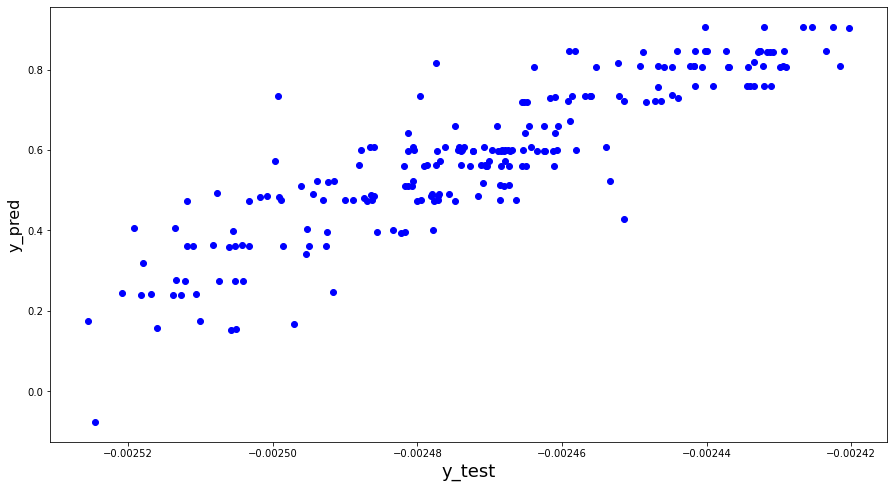

In [132]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(15,8))
plt.scatter(y_test,y_pred,color='blue')
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

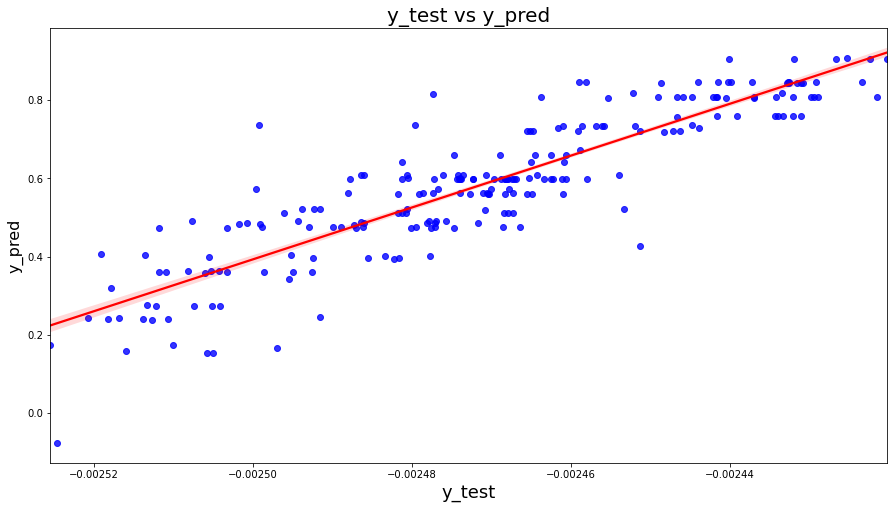

In [133]:
#Regression plot
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.title('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
plt.show()

#### Assumptions of Linear Regression:
- The error terms are normally distributed.
- The training and testing accuracy are nearly equal hence there is no Overfit/Underfit situation.
- The predicted values have linear relationship with the actual values.

#### Conclusion:
The top 5 variables that are seen effecting and benefitting the Bike Rental count are as follows:

- Spring season : -0.2367
- Jan : -0.1216
- Mist :-0.3647
- Year : 0.2459
- Sep : 0.0607

#### Interpretation:
count=0.0607×month_Sep+0.2459×Year-0.0374×summer-0.0854×windspeed−0.3.155×lightsnow−0.0872×mistcloudy−0.2367×spring-0.1101xmonth_Nov-0.1216xmonth_Jan
- We arrived at a very decent model for the the demand for shared bikes with the significant variables
- We can see that Year variable is having the highest coefficient 0.2459, which means if the year changes from 2018 to 2019 the number of bike rentals increases by 0.2459units.

- We also see there are some variables with negative coefficients.
A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease. We have spring, mist+cloudy , light snow variables with negative coefficient. The coefficient value signifies how much the mean of the dependent variable changes given a one-unit change in the independent variable while keeping other variables in the model constant.

#### Business Goals:

- A US bike-sharing provider BoomBikes can focus more on Time for the business to pickup pace .
- We can see demand for bikes was more in 2019 than 2018, so just focus as there is increase in 2019 . 
- The focus can be more on Summer & Winter season, August, September months, Weekends, Working days as they have good influence on bike rentals.
- We can  focus on weathersit variable, we have got negative coefficients for Mist +cloudy and Lightsnow , Spring seasons as they have negative coefficients and are negatively correlated to bike rentals. So we can offer seasonal offers  there to increase the demand.